# NOVELIS CODE ASSESSMENT - FRAUD DETECTION:

## Importing Essential libraries:

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Reading the dataset:

In [136]:
df = pd.read_csv('fraud_final_dataset.csv')

In [137]:
df.head()

,user_id,signup_time,purchase_time,elapsed_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,285108,7/15/2015 4:36,9/10/2015 14:17,2,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2.818400e+09,0,United States
1,131009,1/24/2015 12:29,4/13/2015 4:53,3,31,XGQAJSOUJIZCC,SEO,IE,F,21,3.251268e+09,0,United Kingdom
2,328855,3/11/2015 0:54,4/5/2015 12:23,1,16,VCCTAYDCWKZIY,Direct,IE,M,26,2.727760e+09,0,United States
3,229053,1/7/2015 13:19,1/9/2015 10:12,0,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2.083420e+09,0,Korea Republic of
4,108439,2/8/2015 21:11,4/9/2015 14:26,2,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3.207913e+09,0,Brazil


## Data Exploration:

In [138]:
df.shape

(120000, 13)

We have 120,000 rows of datapoints which is more than enough for a machine learning model to be almost accurate.

In [139]:
df.describe()

,user_id,elapsed_time,purchase_value,age,ip_address,class
count,120000.000000,120000.000000,120000.000000,120000.000000,1.200000e+05,120000.000000
mean,200320.280100,1.860408,36.881475,33.125250,2.151550e+09,0.093875
std,115361.945935,1.250767,18.325855,8.617081,1.248314e+09,0.291656
min,2.000000,0.000000,9.000000,18.000000,9.344714e+04,0.000000
25%,100925.500000,1.000000,22.000000,27.000000,1.085345e+09,0.000000
50%,200037.500000,2.000000,34.000000,33.000000,2.155238e+09,0.000000
75%,300395.500000,3.000000,49.000000,39.000000,3.241268e+09,0.000000
max,400000.000000,4.000000,154.000000,76.000000,4.294850e+09,1.000000


In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         120000 non-null  int64  
 1   signup_time     120000 non-null  object 
 2   purchase_time   120000 non-null  object 
 3   elapsed_time    120000 non-null  int64  
 4   purchase_value  120000 non-null  int64  
 5   device_id       120000 non-null  object 
 6   source          120000 non-null  object 
 7   browser         120000 non-null  object 
 8   sex             120000 non-null  object 
 9   age             120000 non-null  int64  
 10  ip_address      120000 non-null  float64
 11  class           120000 non-null  int64  
 12  country         120000 non-null  object 
dtypes: float64(1), int64(5), object(7)
memory usage: 11.9+ MB


In [141]:
df.isnull().sum()

user_id           0
signup_time       0
purchase_time     0
elapsed_time      0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
country           0
dtype: int64

Fortunately, there are no null values. So, it is easy for us to proceed.

## Data Cleaning & Feature Engineering:

Since, id is just an unique identifier and this won't have any impact on the target variable, let's remove "User ID", "Device ID" from the data. Also removing "IP address" which is also an unique identifier.

In [142]:
df.drop(['user_id', 'device_id','ip_address'], axis = 1, inplace = True) 

"Sign Up time" and "Purchase time" are in object formats. Let's convert that to datetime format.

In [143]:
df['signup_time'] = pd.to_datetime(df['signup_time'])
df['purchase_time'] = pd.to_datetime(df['purchase_time'])

Adding a new feature which is derived from the existing features. The new feature is the number of days from the sign-up day to the first purchase day. This might have some impact with the target variable. My assumption is that a person who is fraud won't take long to make their first purchase after sign-up.

In [144]:
df['signup_to_purchase'] = (df['purchase_time'] - df['signup_time']).dt.days

Also extracting "Hour", "Month", and "Week day" from the "Purchase time" column.

In [145]:
df['weekday'] = df['purchase_time'].dt.weekday
df['month'] = df['purchase_time'].dt.month
df['hour'] = df['purchase_time'].dt.hour

Creating a new feature "Part of the Day" from "Purchase time" column, since we can explore whether there is any impact with the fraudulent transactions with the part of day.

In [146]:
def f(x):
    if (x > 4) and (x <= 8):
        return 'Early Morning'
    elif (x > 8) and (x <= 12 ):
        return 'Morning'
    elif (x > 12) and (x <= 16):
        return'Noon'
    elif (x > 16) and (x <= 20) :
        return 'Eve'
    elif (x > 20) and (x <= 24):
        return'Night'
    elif (x <= 4):
        return'Late Night'

df['part_of_day'] = df['hour'].apply(f)

Dropping "Sign-up time" and "Purchase time" features from the data, as we have already extracted the useful information from those 2 features. Plus we can't use datetime column in a Classification ML model.

Also dropping "hour" column we created, as we have derived "part of day" column from the same.

In [147]:
df.drop(['signup_time', 'purchase_time', 'hour'], axis = 1, inplace = True) 

Converting 0 to Mon, 1 to Tue and so on "weekday" column

In [148]:
days = {0: 'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
df['weekday'] = df['weekday'].replace(days)

Also creating a new column with the weekday column - whether the purchase day is Weekend or not. This might be redundant, but also it might contain some extra information. So, not going to delete one of these features, let Principal Component Analysis will handle it.

In [149]:
def g(x):
  if x in ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']:
    return 0
  elif x in ['Sat', 'Sun']:
    return 1

df['weekend_or_not'] = df['weekday'].apply(g)

Converting the categorical variable "sex" to 0s and 1s.

In [150]:
sex = {'F':0, 'M':1}
df['sex'] = df['sex'].replace(sex)

In [151]:
df.head()

,elapsed_time,purchase_value,source,browser,sex,age,class,country,signup_to_purchase,weekday,month,part_of_day,weekend_or_not
0,2,31,Direct,Chrome,1,49,0,United States,57,Thu,9,Noon,0
1,3,31,SEO,IE,0,21,0,United Kingdom,78,Mon,4,Late Night,0
2,1,16,Direct,IE,1,26,0,United States,25,Sun,4,Morning,1
3,0,29,SEO,Chrome,1,34,0,Korea Republic of,1,Fri,1,Morning,0
4,2,26,Ads,FireFox,1,33,0,Brazil,59,Thu,4,Noon,0


So, this is our data after performing the feature engineering.

Now, let's visualize this data and try to see any patterns over there.

## Exploratory Data Analytics:

Plotting scatter plots of all numerical features in the data

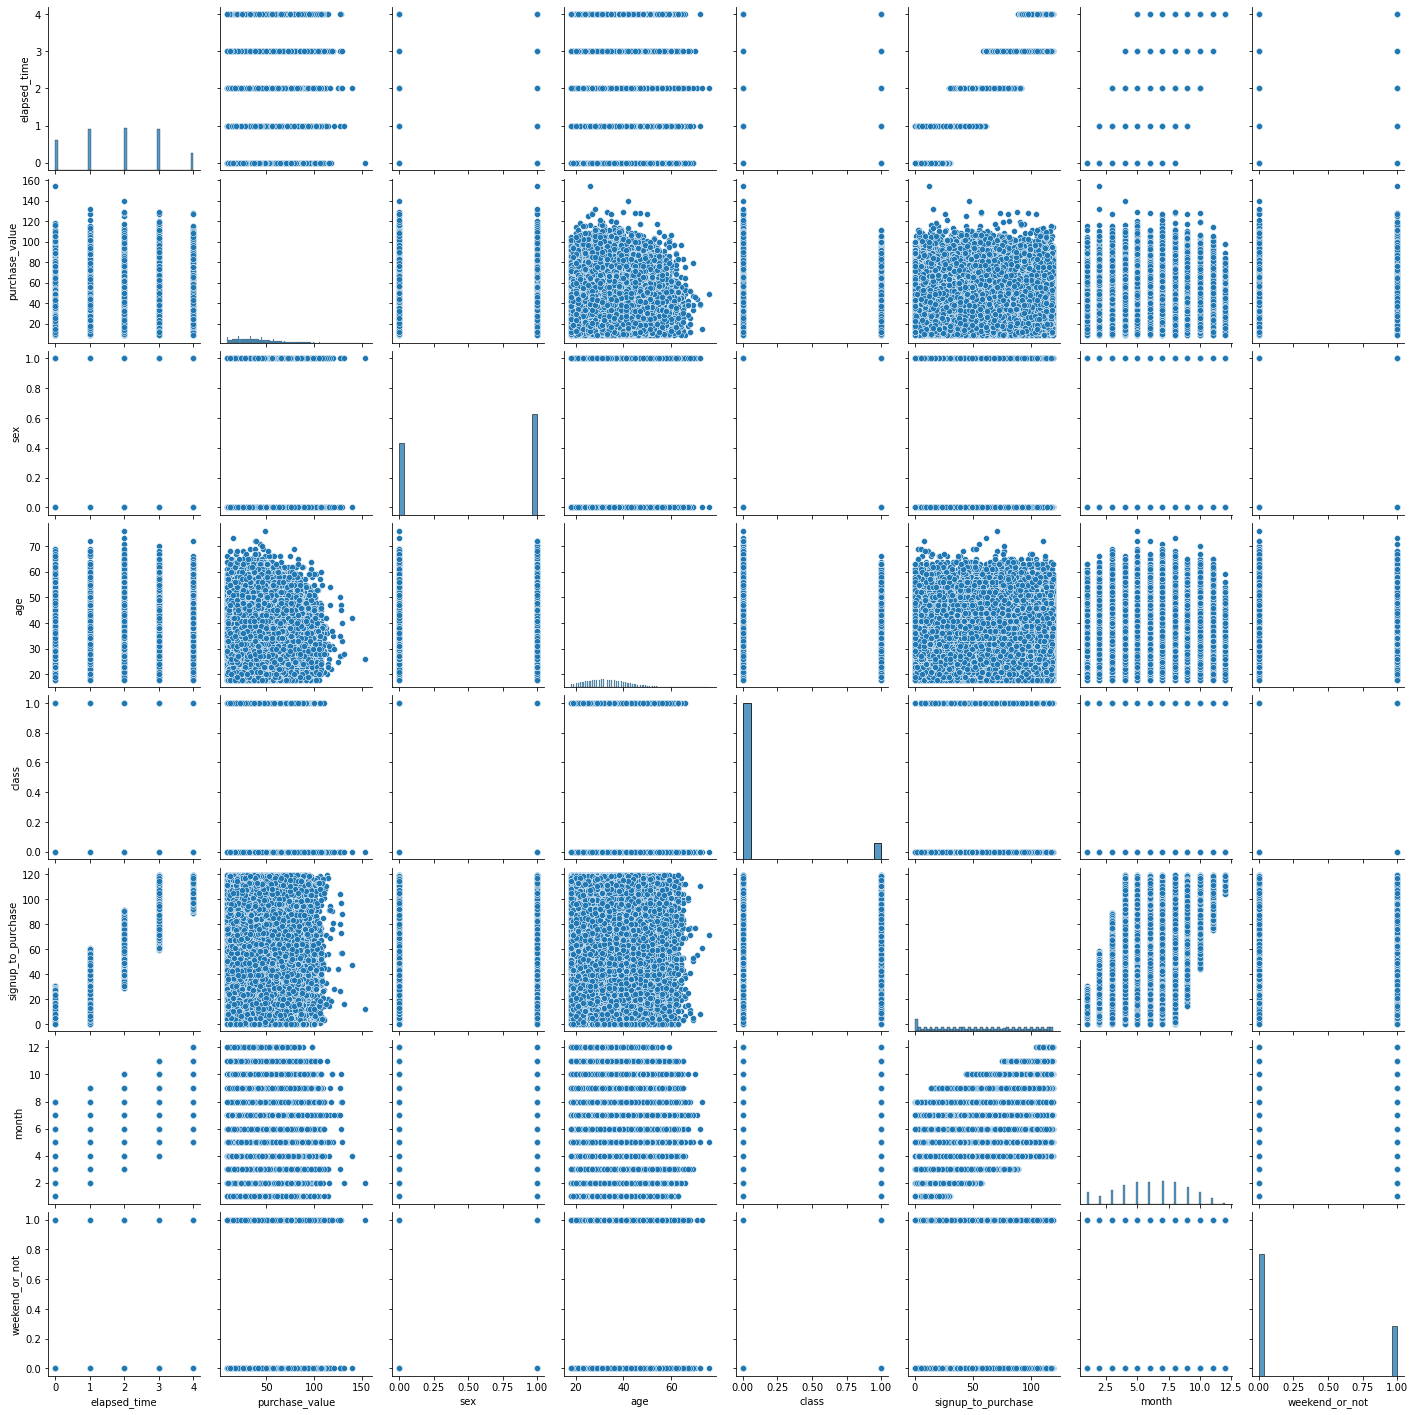

In [152]:
sns.pairplot(df)

Since our target variable is a binary classifier, this plot is not providing much insights. Let's plot the target variables with the other independent categorical variables.

### Source vs Percentage of transaction (fraud or not):

Text(0.5, 1.0, 'Source vs Percentage of transaction (fraud or not)')

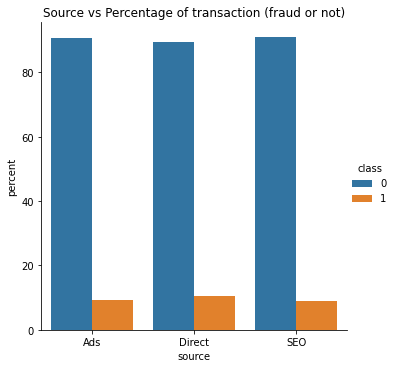

In [153]:
df1 = df.groupby(["source", "class"]).size().reset_index(name='count')
df2 = df.groupby('source')["class"].count().reset_index(name='Total_count')
df_final = df1.merge(df2)
df_final['percent'] = 100*(df_final['count']/df_final['Total_count'])


sns.catplot(x='source', y='percent', hue='class', kind='bar', data=df_final)
plt.title('Source vs Percentage of transaction (fraud or not)')

From the above graph, we can see that the percentage of fraud transactions and normal transactions are almost equal for all three sources - "Ads", "Direct" and "SEO".

### Elapsed time vs Percentage of transaction (fraud or not):

Text(0.5, 1.0, 'Elapsed time vs Percentage of transaction (fraud or not)')

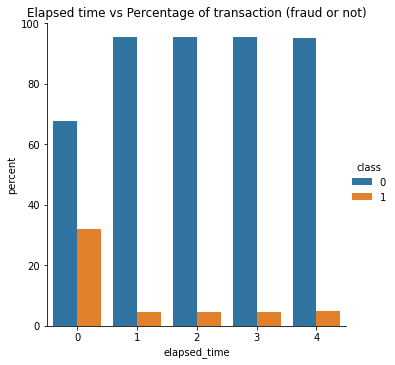

In [154]:
df1 = df.groupby(["elapsed_time", "class"]).size().reset_index(name='count')
df2 = df.groupby('elapsed_time')["class"].count().reset_index(name='Total_count')
df_final = df1.merge(df2)
df_final['percent'] = 100*(df_final['count']/df_final['Total_count'])


sns.catplot(x='elapsed_time', y='percent', hue='class', kind='bar', data=df_final)
plt.title('Elapsed time vs Percentage of transaction (fraud or not)')

We can see something fishy here. The transaction is likely to be fraud, if the elapsed time is "0" than other timings.

### Sex vs Percentage of transaction (fraud or not):

Text(0.5, 1.0, 'Sex vs Percentage of transaction (fraud or not)')

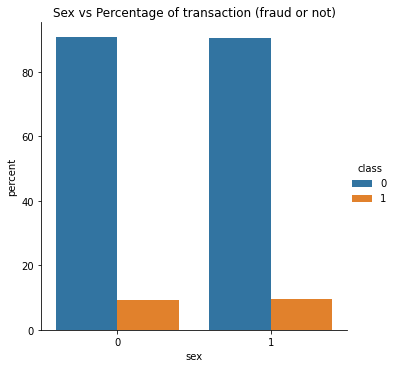

In [155]:
df1 = df.groupby(["sex", "class"]).size().reset_index(name='count')
df2 = df.groupby('sex')["class"].count().reset_index(name='Total_count')
df_final = df1.merge(df2)
df_final['percent'] = 100*(df_final['count']/df_final['Total_count'])


sns.catplot(x='sex', y='percent', hue='class', kind='bar', data=df_final)
plt.title('Sex vs Percentage of transaction (fraud or not)')

From the above graph, we can see that the percentage of fraud transactions and normal transactions are almost equal for both sex.

### Purchase Month vs Percentage of transaction (fraud or not):

Text(0.5, 1.0, 'Purchase Month vs Percentage of transaction (fraud or not)')

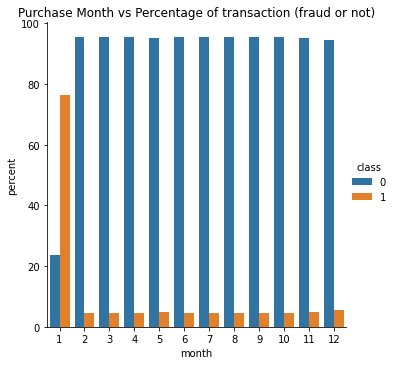

In [156]:
df1 = df.groupby(["month", "class"]).size().reset_index(name='count')
df2 = df.groupby('month')["class"].count().reset_index(name='Total_count')
df_final = df1.merge(df2)
df_final['percent'] = 100*(df_final['count']/df_final['Total_count'])


sns.catplot(x='month', y='percent', hue='class', kind='bar', data=df_final)
plt.title('Purchase Month vs Percentage of transaction (fraud or not)')

From the above graph, we can see that in January month, majority of the fraud transactions have taken place. 

(Maybe fraudsters would like to collect their money in the first month itself and they want to relax for the rest of the year, just my crazy assumption)

### Weekend_or_not vs Percentage of transaction (fraud or not):

Text(0.5, 1.0, 'Weekend_or_not vs Percentage of transaction (fraud or not)')

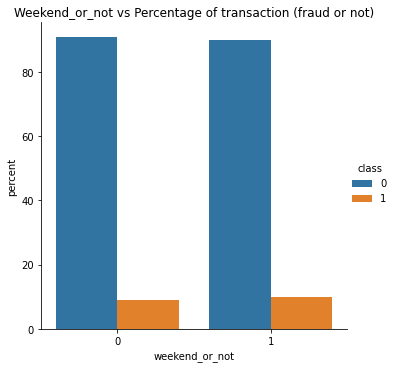

In [157]:
df1 = df.groupby(["weekend_or_not", "class"]).size().reset_index(name='count')
df2 = df.groupby('weekend_or_not')["class"].count().reset_index(name='Total_count')
df_final = df1.merge(df2)
df_final['percent'] = 100*(df_final['count']/df_final['Total_count'])


sns.catplot(x='weekend_or_not', y='percent', hue='class', kind='bar', data=df_final)
plt.title('Weekend_or_not vs Percentage of transaction (fraud or not)')

The transactions are equal for both. No patterns can be found here.

### Browser vs Percentage of transaction (fraud or not):

Text(0.5, 1.0, 'Browser vs Percentage of transaction (fraud or not)')

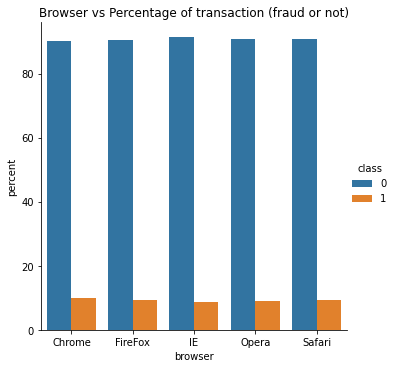

In [158]:
df1 = df.groupby(["browser", "class"]).size().reset_index(name='count')
df2 = df.groupby('browser')["class"].count().reset_index(name='Total_count')
df_final = df1.merge(df2)
df_final['percent'] = 100*(df_final['count']/df_final['Total_count'])


sns.catplot(x='browser', y='percent', hue='class', kind='bar', data=df_final)
plt.title('Browser vs Percentage of transaction (fraud or not)')

Browser also doesn't have any impact with the type of transaction.

Let's check whether it is to do something with the country (like most of the fraudulent transactions are from a specific country or not)

In [159]:
df1 = df.groupby(["country", "class"]).size().reset_index(name='count')
df2 = df.groupby('country')["class"].count().reset_index(name='Total_count')
df_final = df1.merge(df2)
df_final['percent'] = 100*(df_final['count']/df_final['Total_count'])
df_final[df_final['class'] == 1].sort_values(by='percent', ascending=False)

,country,class,count,Total_count,percent
257,Turkmenistan,1,1,1,100.000000
279,Virgin Islands (U.S.),1,1,2,50.000000
178,Namibia,1,8,20,40.000000
151,Luxembourg,1,22,56,39.285714
238,Sri Lanka,1,8,22,36.363636
...,...,...,...,...,...
24,Belarus,1,2,59,3.389831
65,Cyprus,1,1,31,3.225806
174,Morocco,1,3,134,2.238806
224,Serbia,1,1,50,2.000000


In the above table, "precent" indicates the percentage of fraud transactions that are from that specific country. We can't find any pattern here too.

### Weekday vs Percentage of transaction (fraud or not):

Text(0.5, 1.0, 'Weekday vs Percentage of transaction (fraud or not)')

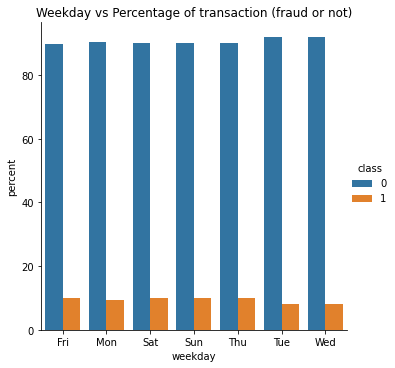

In [160]:
df1 = df.groupby(["weekday", "class"]).size().reset_index(name='count')
df2 = df.groupby('weekday')["class"].count().reset_index(name='Total_count')
df_final = df1.merge(df2)
df_final['percent'] = 100*(df_final['count']/df_final['Total_count'])


sns.catplot(x='weekday', y='percent', hue='class', kind='bar', data=df_final)
plt.title('Weekday vs Percentage of transaction (fraud or not)')

### Part of day vs Percentage of transaction (fraud or not):

Text(0.5, 1.0, 'Part of day vs Percentage of transaction (fraud or not)')

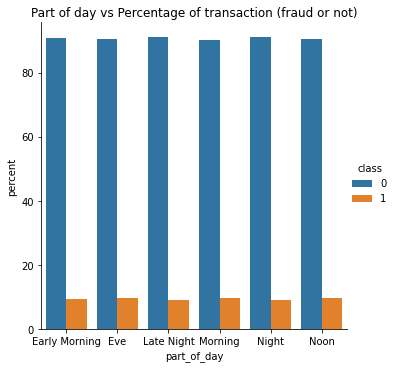

In [161]:
df1 = df.groupby(["part_of_day", "class"]).size().reset_index(name='count')
df2 = df.groupby('part_of_day')["class"].count().reset_index(name='Total_count')
df_final = df1.merge(df2)
df_final['percent'] = 100*(df_final['count']/df_final['Total_count'])


sns.catplot(x='part_of_day', y='percent', hue='class', kind='bar', data=df_final)
plt.title('Part of day vs Percentage of transaction (fraud or not)')

I expected that we can see some patterns with the "weekday" or "part of day", but the results are not supporting our assumptions.

From all these graphs, we can understand that the fraudsters are working hard to make sure that they won't leave any patterns. But still we noticed some patterns. Let's apply PCA and build machine learning models, let them detect the patterns that we missed to visualize.

## Data Preprocessing:

### One-Hot Encoding:

Categorical features can't be fed into the machine learning model, so performing "One Hot Encoding" on categorical features.

In [162]:
df1 = pd.get_dummies(df.source,prefix='source',drop_first=True)
df2 = pd.get_dummies(df.browser,prefix='browser',drop_first=True)
df3 = pd.get_dummies(df.country,prefix='country',drop_first=True)
df4 = pd.get_dummies(df.weekday,prefix='weekday',drop_first=True)
df5 = pd.get_dummies(df.part_of_day,prefix='part_of_day',drop_first=True)

In [163]:
df = pd.concat([df,df1, df2, df3, df4, df5],axis=1)
df.drop(['source', 'browser', 'country', 'weekday', 'part_of_day'],axis=1,inplace=True)
df.head()

,elapsed_time,purchase_value,sex,age,class,signup_to_purchase,month,weekend_or_not,source_Direct,source_SEO,...,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,part_of_day_Eve,part_of_day_Late Night,part_of_day_Morning,part_of_day_Night,part_of_day_Noon
0,2,31,1,49,0,57,9,0,1,0,...,0,0,1,0,0,0,0,0,0,1
1,3,31,0,21,0,78,4,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,1,16,1,26,0,25,4,1,1,0,...,0,1,0,0,0,0,0,1,0,0
3,0,29,1,34,0,1,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,2,26,1,33,0,59,4,0,0,0,...,0,0,1,0,0,0,0,0,0,1


### Standardization:

Standardizing the numerical features which are not 0s and 1s

In [164]:
from sklearn.preprocessing import StandardScaler
cols_to_scale = ['purchase_value', 'age', 'signup_to_purchase']
scaler = StandardScaler()
scaler.fit(df[cols_to_scale])
df[cols_to_scale] = scaler.transform(df[cols_to_scale])

Extracting X (independent variables) and y (target variable) from the data

In [165]:
X = df.drop('class',axis=1)
y = df['class']

In [166]:
X.shape

(120000, 200)

### Principal Component Analysis (Dimensionality reduction):

Initially, I tried to run with the actual data without PCA. Since the data contains 200 independent variables and 120,000 rows, it is taking hours to train some ML models. So, PCA is performed for dimensionality reduction. This also helps to filter the most important features from the dataset.

In [167]:
from sklearn.decomposition import PCA
pca=PCA(n_components=4)

Let's take the most important 4 features for building the machine learning model.

In [168]:
pca.fit(X)

PCA(n_components=4)

In [169]:
X=pca.transform(X)

In [170]:
print(X.shape)

(120000, 4)


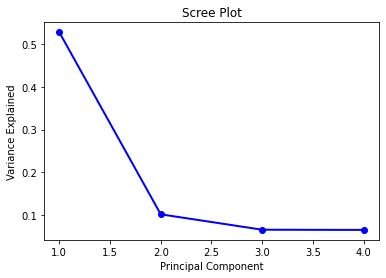

In [171]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [172]:
pca.explained_variance_ratio_.sum()

0.7608439631432706

76% of the variance is captured by applying PCA of 4. Though, this is not ideal, let's proceed with it and see how it works to build machine learning models.

## Classification Machine Learning models:

### Splitting the dataset into Train and Test:

In [173]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y.values, test_size=0.2, random_state=0)

### 1. Logistic Regression:

In [174]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [175]:
y_pred = classifier.predict(X_test)

In [176]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[21739     0]
 [ 2261     0]]


In [177]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     21739
           1       0.00      0.00      0.00      2261

    accuracy                           0.91     24000
   macro avg       0.45      0.50      0.48     24000
weighted avg       0.82      0.91      0.86     24000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Though Logistic regression would be the basic model for Binary Classification, the results we obtained are good enough.

Since, this is a fraud detection problem and the dataset is imbalanced, evaluating performance of the model using "accuarcy" won't be helpful.

We can look at "Recall" and "Precision" to evaluate metric of the model. Since, "F1 score" utilizes both recall and precision into account, let's use it as a primary evaluation metric here.

### 2. K Nearest Neighbors:

In [178]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 4, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

In [179]:
y_pred = classifier.predict(X_test)

In [180]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[21622   117]
 [ 1057  1204]]


In [181]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     21739
           1       0.91      0.53      0.67      2261

    accuracy                           0.95     24000
   macro avg       0.93      0.76      0.82     24000
weighted avg       0.95      0.95      0.95     24000



To find the best k-value, let's loop through k-values from 1 to 40.

In [182]:
error_rate = []

# Will take some time
for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

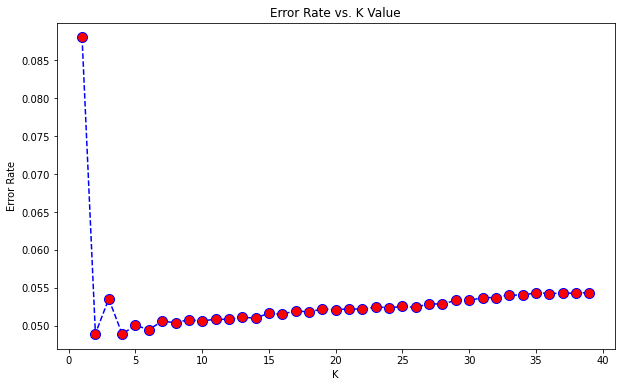

In [183]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

We can see that k=4 has the minimum error rate. Coincidentally, we have built out model using k=4.

### 3. Support Vector Classifier:

In [184]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(X_train, y_train)

SVC(kernel='linear', random_state=0)

In [185]:
y_pred = classifier.predict(X_test)

In [186]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[21739     0]
 [ 2261     0]]


In [187]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     21739
           1       0.00      0.00      0.00      2261

    accuracy                           0.91     24000
   macro avg       0.45      0.50      0.48     24000
weighted avg       0.82      0.91      0.86     24000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 4. Naive Bayes Classifier:

In [188]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB()

In [189]:
y_pred = classifier.predict(X_test)

In [190]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[21502   237]
 [ 1044  1217]]


In [191]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     21739
           1       0.84      0.54      0.66      2261

    accuracy                           0.95     24000
   macro avg       0.90      0.76      0.81     24000
weighted avg       0.94      0.95      0.94     24000



### 5. Decision Tree Classifier:

In [192]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [193]:
y_pred = classifier.predict(X_test)

In [194]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[20657  1082]
 [ 1001  1260]]


In [195]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     21739
           1       0.54      0.56      0.55      2261

    accuracy                           0.91     24000
   macro avg       0.75      0.75      0.75     24000
weighted avg       0.91      0.91      0.91     24000



### 6. Random Forest Classifier:

In [196]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

In [197]:
y_pred = classifier.predict(X_test)

In [198]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[21704    35]
 [ 1052  1209]]


In [199]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     21739
           1       0.97      0.53      0.69      2261

    accuracy                           0.95     24000
   macro avg       0.96      0.77      0.83     24000
weighted avg       0.96      0.95      0.95     24000



### Hyper-parameter tuning of Random Forest Classifier using GridSearchCV:

In [200]:
from sklearn.model_selection import GridSearchCV

forest = RandomForestClassifier(random_state = 1)

n_estimators = [100, 300]
max_depth = [5, 8]

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth)

gridF = GridSearchCV(forest, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [201]:
bestF.best_params_

{'max_depth': 8, 'n_estimators': 100}

### Building the Random Forest Classifier using the best parameters obtained using Hyperparameter tuning:

In [202]:
classifier = RandomForestClassifier(n_estimators = 100, max_depth = 8, criterion = 'entropy', random_state = 0)

In [203]:
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=8, random_state=0)

In [204]:
y_pred = classifier.predict(X_test)

In [205]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[21720    19]
 [ 1053  1208]]


In [206]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     21739
           1       0.98      0.53      0.69      2261

    accuracy                           0.96     24000
   macro avg       0.97      0.77      0.83     24000
weighted avg       0.96      0.96      0.95     24000



### 7. Neural Networks:

In [207]:
X_train.shape

(96000, 4)

In [208]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU,PReLU,ELU
from keras.layers import Dropout
from tensorflow import keras
from tensorflow.keras import layers

In [209]:
classifier = Sequential()
classifier.add(Dense(500, input_dim=4, activation= "relu"))
classifier.add(Dense(100, activation= "relu"))
classifier.add(Dense(50, activation= "relu"))
classifier.add(Dense(1, activation= "sigmoid"))

In [210]:
classifier.compile(loss= "binary_crossentropy" , optimizer="adam", metrics=["accuracy"])
classifier.fit(X_train, y_train, epochs=20)

Epoch 1/20
3000/3000 [==============================] - 10s 3ms/step - loss: 0.2113 - accuracy: 0.9441
Epoch 2/20
3000/3000 [==============================] - 9s 3ms/step - loss: 0.1960 - accuracy: 0.9508
Epoch 3/20
3000/3000 [==============================] - 9s 3ms/step - loss: 0.1920 - accuracy: 0.9523
Epoch 4/20
3000/3000 [==============================] - 9s 3ms/step - loss: 0.1911 - accuracy: 0.9524
Epoch 5/20
3000/3000 [==============================] - 10s 3ms/step - loss: 0.1889 - accuracy: 0.9530
Epoch 6/20
3000/3000 [==============================] - 10s 3ms/step - loss: 0.1884 - accuracy: 0.9531
Epoch 7/20
3000/3000 [==============================] - 9s 3ms/step - loss: 0.1882 - accuracy: 0.9533
Epoch 8/20
3000/3000 [==============================] - 9s 3ms/step - loss: 0.1875 - accuracy: 0.9532
Epoch 9/20
3000/3000 [==============================] - 9s 3ms/step - loss: 0.1872 - accuracy: 0.9536
Epoch 10/20
3000/3000 [==============================] - 9s 3ms/step - loss: 0.

In [211]:
pred = (classifier.predict(X_test) > 0.5).astype("int32")

In [212]:
pred

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int32)

In [213]:
cm = confusion_matrix(y_test, pred)
print(cm)

[[21700    39]
 [ 1052  1209]]


In [214]:
cr = classification_report(y_test, pred)
print(cr)

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     21739
           1       0.97      0.53      0.69      2261

    accuracy                           0.95     24000
   macro avg       0.96      0.77      0.83     24000
weighted avg       0.96      0.95      0.95     24000



### Hyper-parameter tuning to find the best combination of layers:

In [215]:
!pip install -U keras-tuner
from kerastuner.tuners import RandomSearch

In [216]:
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [217]:
tuner = RandomSearch(
    build_model,
    objective='accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='Fraud Detection')

INFO:tensorflow:Reloading Oracle from existing project my_dir/Fraud Detection/oracle.json
INFO:tensorflow:Reloading Tuner from my_dir/Fraud Detection/tuner0.json


In [218]:
tuner.search_space_summary()

Search space summary
Default search space size: 22
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_5 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_6 (Int)
{'default': None, 'co

In [219]:
tuner.search(X_train, y_train,
             epochs=5,
             validation_data=(X_test, y_test))

INFO:tensorflow:Oracle triggered exit


In [220]:
tuner.results_summary()

Results summary
Results in my_dir/Fraud Detection
Showing 10 best trials
Objective(name='accuracy', direction='max')
Trial summary
Hyperparameters:
num_layers: 20
units_0: 256
units_1: 448
learning_rate: 0.0001
units_2: 32
units_3: 32
units_4: 32
units_5: 32
units_6: 32
units_7: 32
units_8: 32
units_9: 32
units_10: 32
units_11: 32
units_12: 32
units_13: 32
units_14: 32
units_15: 32
units_16: 32
units_17: 32
units_18: 32
units_19: 32
Score: 0.906208336353302
Trial summary
Hyperparameters:
num_layers: 11
units_0: 64
units_1: 352
learning_rate: 0.0001
units_2: 128
units_3: 160
units_4: 224
units_5: 480
units_6: 224
units_7: 352
units_8: 32
units_9: 64
units_10: 448
units_11: 64
units_12: 512
units_13: 96
units_14: 256
units_15: 64
units_16: 256
units_17: 256
units_18: 352
units_19: 448
Score: 0.906208336353302
Trial summary
Hyperparameters:
num_layers: 3
units_0: 64
units_1: 416
learning_rate: 0.01
units_2: 192
units_3: 64
units_4: 512
units_5: 96
units_6: 224
units_7: 480
units_8: 160
un

### Training the Neural Networks using the best combination obtained:

In [221]:
classifier = Sequential()
classifier.add(Dense(160, input_dim=4, activation= "relu"))
classifier.add(Dense(256, activation= "relu"))
classifier.add(Dense(32, activation= "relu"))
classifier.add(Dense(32, activation= "relu"))
classifier.add(Dense(32, activation= "relu"))
classifier.add(Dense(32, activation= "relu"))
classifier.add(Dense(32, activation= "relu"))
classifier.add(Dense(32, activation= "relu"))
classifier.add(Dense(32, activation= "relu"))
classifier.add(Dense(32, activation= "relu"))
classifier.add(Dense(32, activation= "relu"))
classifier.add(Dense(32, activation= "relu"))
classifier.add(Dense(1, activation= "sigmoid"))

In [222]:
opt = keras.optimizers.Adam(learning_rate=0.01)
classifier.compile(loss= "binary_crossentropy", optimizer=opt, metrics=["accuracy"])
classifier.fit(X_train, y_train, epochs=20)

Epoch 1/20
3000/3000 [==============================] - 25s 8ms/step - loss: 0.2755 - accuracy: 0.9144
Epoch 2/20
3000/3000 [==============================] - 23s 8ms/step - loss: 0.3123 - accuracy: 0.9062
Epoch 3/20
3000/3000 [==============================] - 15s 5ms/step - loss: 0.3121 - accuracy: 0.9062
Epoch 4/20
3000/3000 [==============================] - 14s 5ms/step - loss: 0.3119 - accuracy: 0.9062
Epoch 5/20
3000/3000 [==============================] - 13s 4ms/step - loss: 0.3118 - accuracy: 0.9062
Epoch 6/20
3000/3000 [==============================] - 13s 4ms/step - loss: 0.3116 - accuracy: 0.9062
Epoch 7/20
3000/3000 [==============================] - 21s 7ms/step - loss: 0.3117 - accuracy: 0.9062
Epoch 8/20
3000/3000 [==============================] - 15s 5ms/step - loss: 0.3114 - accuracy: 0.9062
Epoch 9/20
3000/3000 [==============================] - 13s 4ms/step - loss: 0.3114 - accuracy: 0.9062
Epoch 10/20
3000/3000 [==============================] - 15s 5ms/step - l

In [ ]:
pred = (classifier.predict(X_test) > 0.5).astype("int32")

In [ ]:
cm = confusion_matrix(y_test, pred)
print(cm)

In [ ]:
cr = classification_report(y_test, pred)
print(cr)

## BEST MODEL:

Comparing the "F1 score" of every model, we can see that Random Forest Classifier performs the best.

Also the "Recall", "Precision" and "Accuracy" of the Random Forest Classifier performed better than other model. So, let's train the entire dataset using Random Forest Classifier.

In [225]:
final_model = RandomForestClassifier(n_estimators = 100, max_depth = 8, criterion = 'entropy', random_state = 0)

In [226]:
final_model.fit(X, y)

RandomForestClassifier(criterion='entropy', max_depth=8, random_state=0)

## Saving the model parameters for further use:

In [227]:
import pickle
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(final_model, open(filename, 'wb'))
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))